In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df=pd.read_csv('../../data/TimeSeries/checkoutstimeseries.csv',parse_dates=['Year-Month'])
df.head()


,Unnamed: 0,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
0,0,2005-04-01,143053,0,37432,32157,0,40021
1,1,2005-05-01,227864,0,58138,53305,0,62088
2,2,2005-06-01,287908,0,70580,67821,0,76130
3,3,2005-07-01,195018,0,49752,48457,0,50441
4,4,2005-08-01,210033,0,55664,53192,0,54818


In [4]:
df.columns

Index(['Unnamed: 0', 'Year-Month', 'BOOK', 'EBOOK', 'SOUNDDISC', 'VIDEODISC',
       'AUDIOBOOK', 'Other'],
      dtype='object')

In [5]:
#We don't need the first column, so we drop it.
df = df.drop('Unnamed: 0', axis=1)


In [6]:
df.head()

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
0,2005-04-01,143053,0,37432,32157,0,40021
1,2005-05-01,227864,0,58138,53305,0,62088
2,2005-06-01,287908,0,70580,67821,0,76130
3,2005-07-01,195018,0,49752,48457,0,50441
4,2005-08-01,210033,0,55664,53192,0,54818


In [7]:
#Our data is unreliable after April of 2024, so we drop the rows after this.

df = df.drop(df[df['Year-Month'] > pd.to_datetime('2024-04-01') ].index)

In [8]:
df.tail()

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
224,2023-12-01,218063,271133,14063,46244,220101,8465
225,2024-01-01,249991,286052,14163,48465,241287,9470
226,2024-02-01,227572,257818,14385,45266,218335,9008
227,2024-03-01,240492,269650,14148,47753,232102,9279
228,2024-04-01,232015,258261,13424,44527,221409,9053


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
#Make our test-train-split
df_train=df[df['Year-Month']< pd.to_datetime('2023-05-01')]
df_test=df[df['Year-Month']>= pd.to_datetime('2023-05-01')]

In [11]:
df_test.head(13)

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
217,2023-05-01,234008,245842,13735,42223,199974,7133
218,2023-06-01,243120,244555,13883,42370,201215,7520
219,2023-07-01,254000,264058,13274,42414,212350,7989
220,2023-08-01,259623,262905,14209,44633,217048,8623
221,2023-09-01,239205,252549,12838,42896,208961,8168
222,2023-10-01,242487,260825,12756,44176,216269,8671
223,2023-11-01,229088,255659,12904,42698,211135,8650
224,2023-12-01,218063,271133,14063,46244,220101,8465
225,2024-01-01,249991,286052,14163,48465,241287,9470
226,2024-02-01,227572,257818,14385,45266,218335,9008


## Visualizations and Data Exploration: 

We plot our time series to see their overall form: 

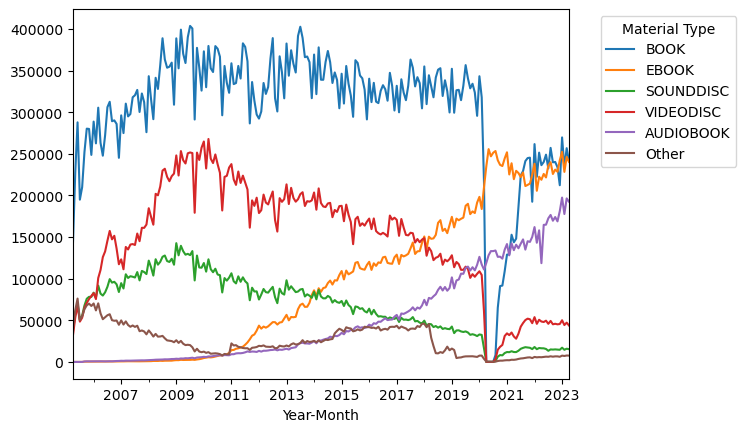

In [12]:
df_train.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other' ])
plt.legend(title='Material Type',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We plot the autocorrelation of each time series to understand the stationarity and seasonality of each series.

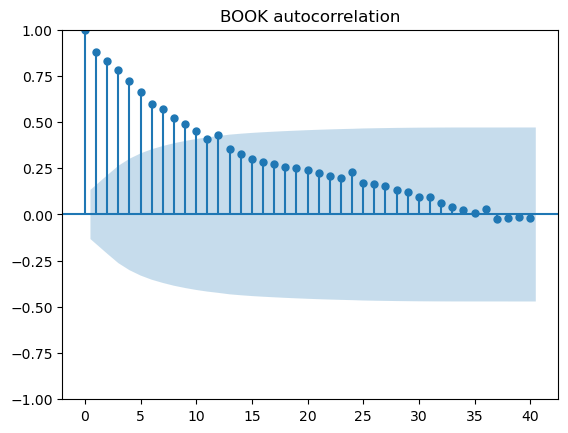

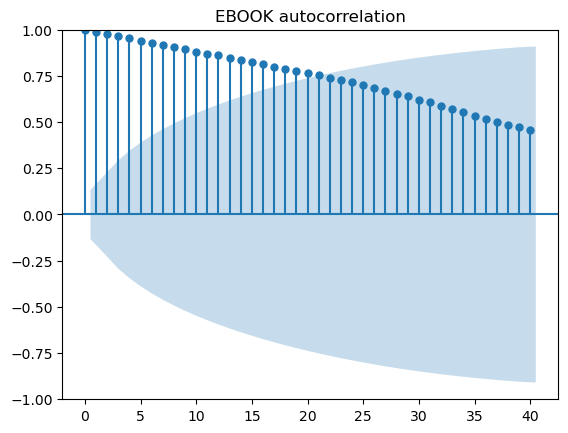

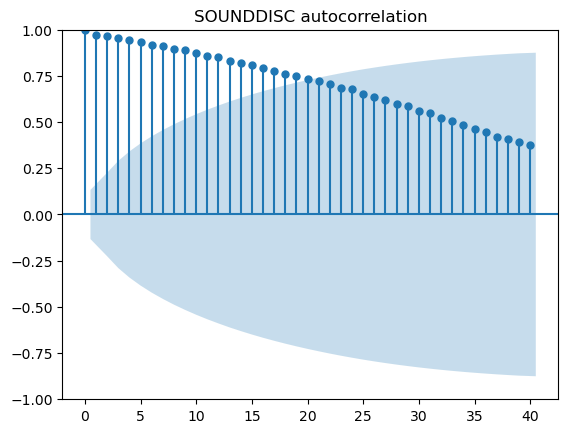

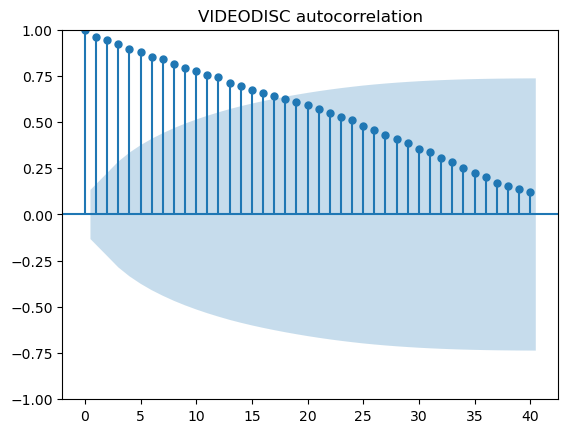

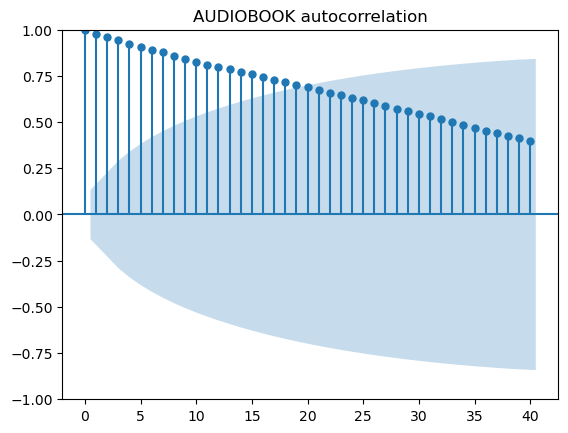

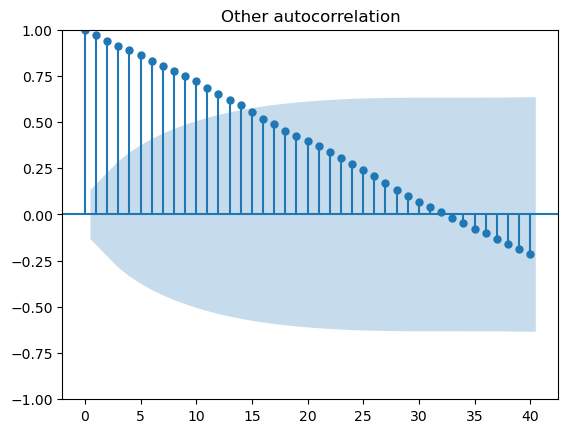

In [13]:
#Let's see how much autocorrelation there is
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#get list of materials forecast for
materials=['BOOK','EBOOK','SOUNDDISC','VIDEODISC','AUDIOBOOK','Other']

for x in materials:
    plot_acf(df_train[x], lags=40)
    plt.title(x + ' autocorrelation')
    plt.show()


From the slow decay of the autocorrelation for each series, we see that the series are not stationary. The bump at lags 12 and 24 in the BOOK time series seems to indicate some form of yearly seasonality; however, it is unclear if the other time series have such seasonality. 

Another way to consider the trend and seasonality of the time series is with Seasonal-Trend decomposition using LOESS (STL). STL using LOESS (locally estimated scatterplot smoothing) to decompose the time series into trend, season, and residual, allowing from nonlinear trends and changing seasonality. 

BOOK


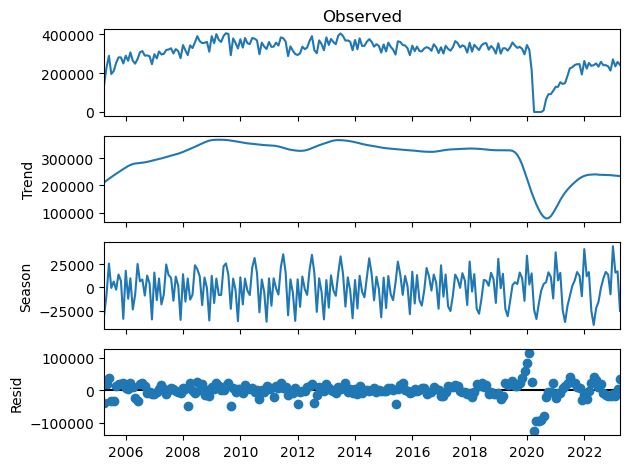


EBOOK


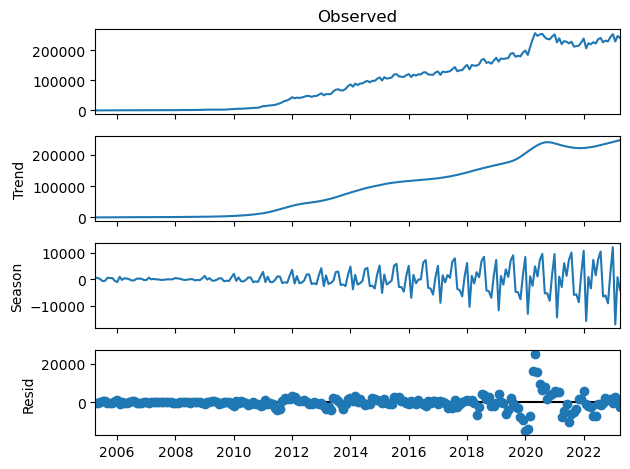


SOUNDDISC


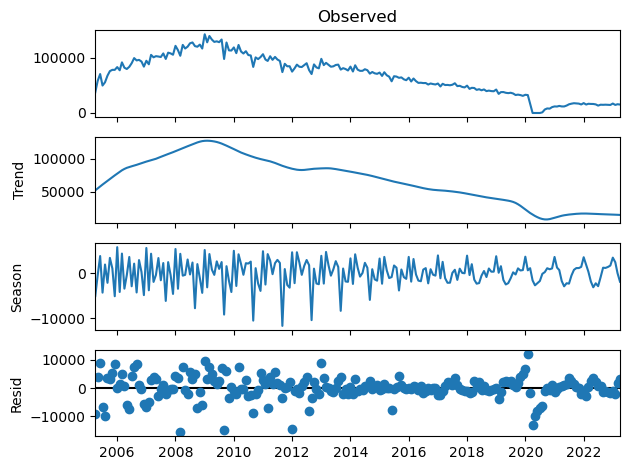


VIDEODISC


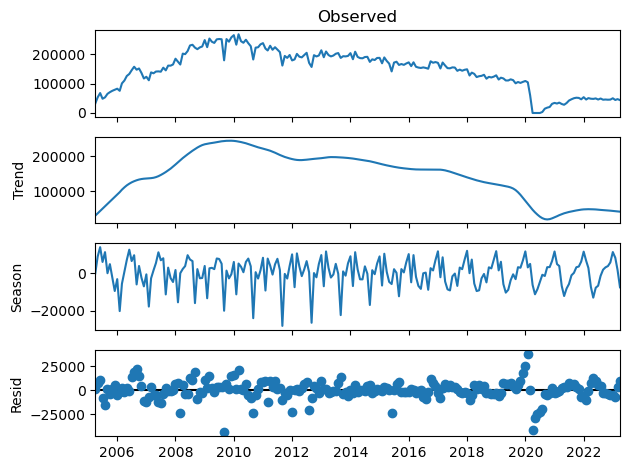


AUDIOBOOK


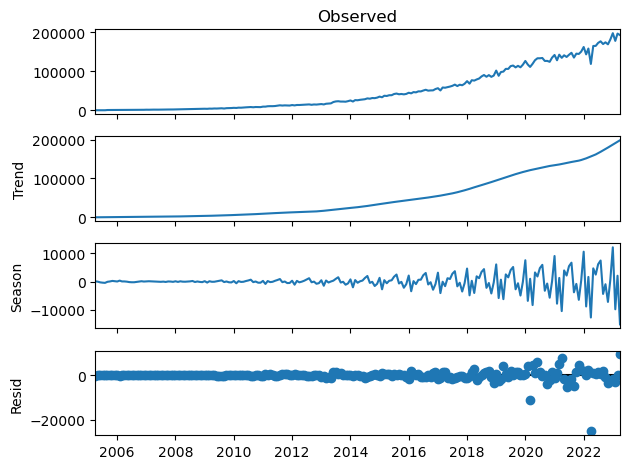


Other


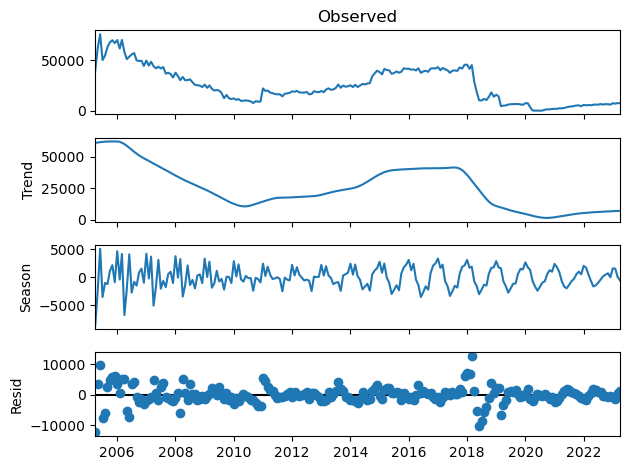

In [14]:
from statsmodels.tsa.seasonal import STL

# Decompose the time series
for material in materials:
    df_seasonal = pd.DataFrame(df_train[material].values, index=df_train['Year-Month'], columns=[material])
    print(material)
    stl= STL(df_seasonal, seasonal=13)
    res = stl.fit()
    fig = res.plot()
    plt.show()
    print()

We see that BOOK has fairly even seasonality throughout its history, whereas EBOOK and AUDIOBOOK develop more seasonality with time which makes sense given the increase in popularity of these materials with time. The seasonality in VIDEODISC, SOUNDDISC, and OTHER is seen throughout the history, but seems to decrease in frequency in the later years. 

## Forecasting: 

We would like to use ARIMA to forecast our time series, while also accounting for the seasonality. This can be done with STLForecast, which will subtract the seasonal component from the time series, forecast on the deseasonalized time series via ARIMA to get the forecast of the trend and residual components, forecast the seasonality under the assumption that future seaonal components will repeat the last observed seasonal cycle, and add the deseasonalized and seasonal components together to get the final forecast. 

We first was to consider what ARIMA model to use for each time series. We consider the partial autocorrelation functions of the deseasonalized data to gain intuition on what would be the best model order: 

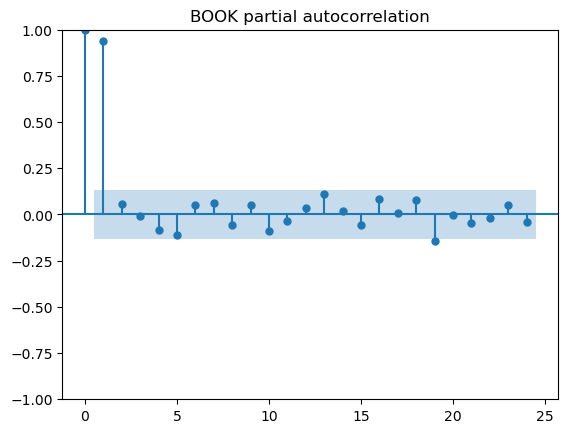

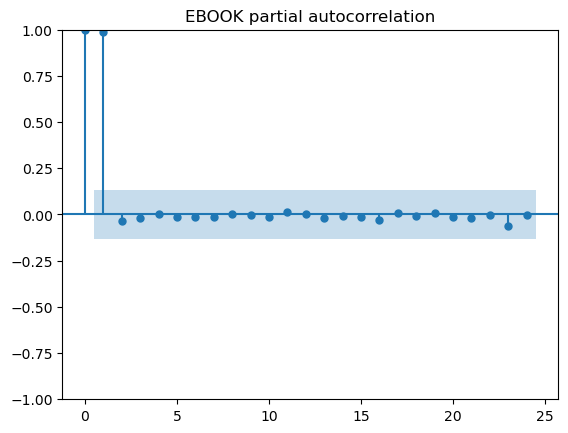

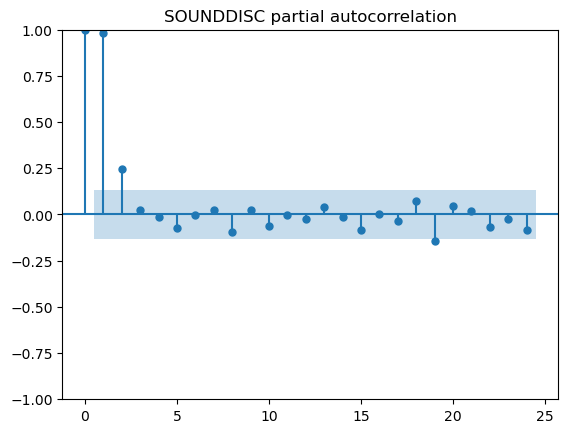

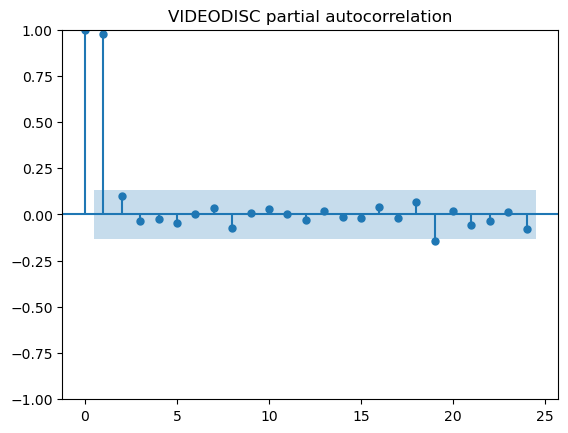

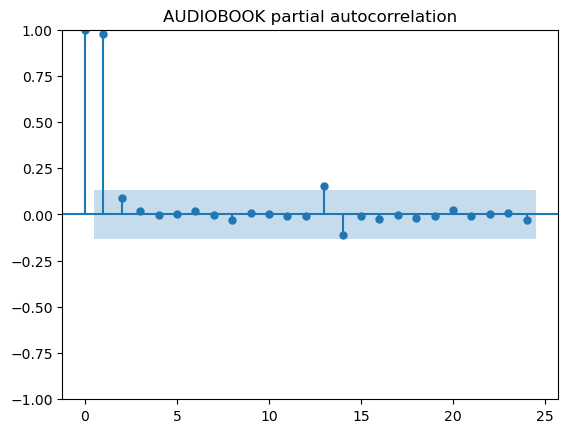

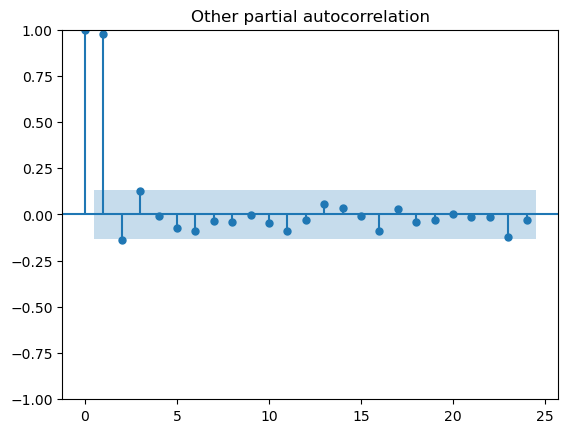

In [15]:
from statsmodels.tsa.seasonal import STL


# Decompose the time series
for material in materials:
    df_seasonal = pd.DataFrame(df_train[material].values, index=df_train['Year-Month'], columns=[material])
    stl= STL(df_seasonal, seasonal=13)
    res = stl.fit()
    # Get series without seasonality
    deseasonalized = df_seasonal[material].values- res.seasonal
    plot_pacf(deseasonalized)
    plt.title(material + ' partial autocorrelation')
    plt.show()
    

From these graphs, we would expect the most the time series to have an AR(1) model, with SOUNDDISC possibly having an AR(2) model.

We can also use autoarima to obtain the best ARIMA model. We do this for the whole train time series as well as the time series pre-2020 as COVID yields a significant shock in our data that should be anamolous. 

In [318]:
import pmdarima as pm

orders = []

# Decompose the time series
for material in materials:
    df_seasonal = pd.DataFrame(df_train[material].values, index=df_train['Year-Month'], columns=[material])
    stl= STL(df_seasonal, seasonal=7)
    res = stl.fit()
    # Get series without seasonality
    deseasonalized = df_seasonal[material].values- res.seasonal
    # Run autoarima on this data
    autoarima=pm.auto_arima(deseasonalized)
    orders.append(autoarima.order)
    print(material, ': ', autoarima.order)

orders_dict = dict(zip(materials, orders))

BOOK :  (0, 1, 0)
EBOOK :  (1, 1, 0)
SOUNDDISC :  (1, 2, 1)
VIDEODISC :  (1, 2, 1)
AUDIOBOOK :  (1, 2, 2)
Other :  (3, 1, 2)


In [306]:
from statsmodels.tsa.seasonal import STL
import pmdarima as pm

df_train_preCOVID = df_train[df_train['Year-Month'] < pd.to_datetime('2020-01-01') ]

orders_preCOVID = []

# Decompose the time series
for material in materials:
    df_seasonal = pd.DataFrame(df_train_preCOVID[material].values, index=df_train_preCOVID['Year-Month'], columns=[material])
    stl= STL(df_seasonal, seasonal=13)
    res = stl.fit()
    # Get series without seasonality
    deseasonalized = df_seasonal[material].values- res.seasonal
    # Run autoarima on this data
    autoarima=pm.auto_arima(deseasonalized)
    #pm.auto_arima(df_train['BOOK'].diff()[1:], seasonal=True, m=12)
    orders_preCOVID.append(autoarima.order)
    print(material, ': ', autoarima.order)


orders_preCOVID_dict = dict(zip(materials, orders_preCOVID))


BOOK :  (0, 1, 0)
EBOOK :  (1, 2, 1)
SOUNDDISC :  (1, 2, 2)
VIDEODISC :  (0, 2, 2)
AUDIOBOOK :  (0, 2, 2)
Other :  (1, 1, 0)


The orders of ARIMA are similar for pre-COVID data and all data, but we will use the pre-COVID values. 

### Baseline Prediction Option #1: Linear Trend Model

A baseline linear trend model will assume that the time series is a linear function of time plus some random noise, i.e.:

$$
f(t) = \beta_0 + \beta_1 t + \epsilon_t
$$

where $\beta_0, \beta_1 \in \mathbb{R}$ and $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$ is guassian white noise error term.


#### Fitting the model

To estimate $\beta_0, \ \beta_1$ we can fit a linear regression model using the time point as the feature you are regressing on.

####  Linear trend forecast

Our forecase simply predicts $y_t = \beta_0 + \beta_1 t$ for $t>n$.

In [323]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from sklearn.linear_model import LinearRegression

In [325]:
# Time Series Cross Valididation object
tscv=TimeSeriesSplit(n_splits=12, test_size=1)

# Dictionary to go from Year-Month to row index of df
month_dict = dict(zip(df['Year-Month'], df.index))

# Baseline prediction
baseline_preds=pd.DataFrame(index=df_train.index, columns=materials)
# STL predictions
STL_preds=pd.DataFrame(index=df_train['Year-Month'], columns=materials)

## Make the LinearRegression object for baseline predictions
baseline_linear = LinearRegression()

for train_index, test_index in tscv.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    for material in materials: 
        #Baseline Predictions
        baseline_linear.fit(X=np.array(train_index).reshape(-1,1),y=df_tt[material])
        baseline_preds.loc[test_index,material]=baseline_linear.predict(X=np.array(test_index).reshape(-1,1))


        #STL Predictions
        df_seasonal = pd.DataFrame(df_tt[material].values, index=df_tt['Year-Month'], columns=[material])
        df_seasonal = df_seasonal.asfreq('MS')
        stlf = STLForecast(df_seasonal, ARIMA, model_kwargs=dict(order=orders_preCOVID_dict[material], freq=df_seasonal.index.inferred_freq))
        #stlf = STLForecast(df_seasonal, ARIMA, model_kwargs=dict(order=orders_dict[material], freq=df_seasonal.index.inferred_freq))
        stlf_res = stlf.fit()
        forecast = stlf_res.forecast(1)
        date = forecast.index.to_pydatetime()[0]
        STL_preds.loc[date,material]= forecast.values[0]


STL_preds = STL_preds.reset_index().dropna()
baseline_preds.insert(0,'Year-Month', df_train['Year-Month'])
baseline_preds = baseline_preds.dropna()


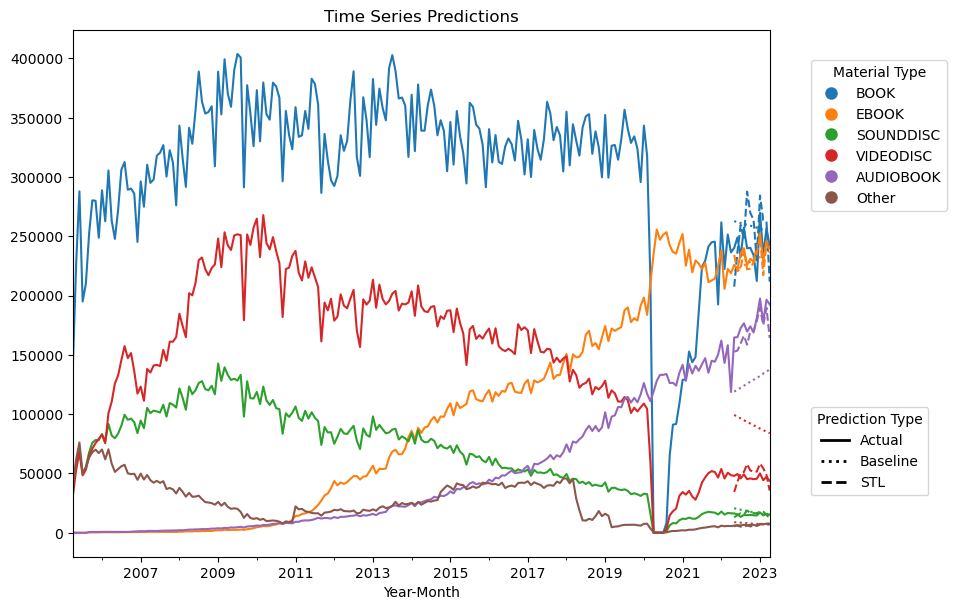

In [326]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Define corresponding colors for materials
colors = dict(zip(materials, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']))

# Define linestyles for different prediction types
linestyles = {'Actual': '-', 'Baseline': ':', 'STL': '--'}

# Plot predictions with whole time series
fig, ax = plt.subplots(figsize=(12, 6))
df_train.plot(x='Year-Month', y=materials, color=colors, ax=ax)
baseline_preds.plot(x='Year-Month', y=materials, ls=linestyles['Baseline'], color=colors, ax=ax)
STL_preds.plot(x='Year-Month', y=materials, ls=linestyles['STL'], color=colors, ax=ax)

# Create custom legends
color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

# Add legends outside the plot
color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.05, 0.8))
ax.add_artist(color_legend)  # Add material type legend first
linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.05, 0.2))

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
plt.title('Time Series Predictions')
plt.show()

We can also take a closer look at our predictions: 

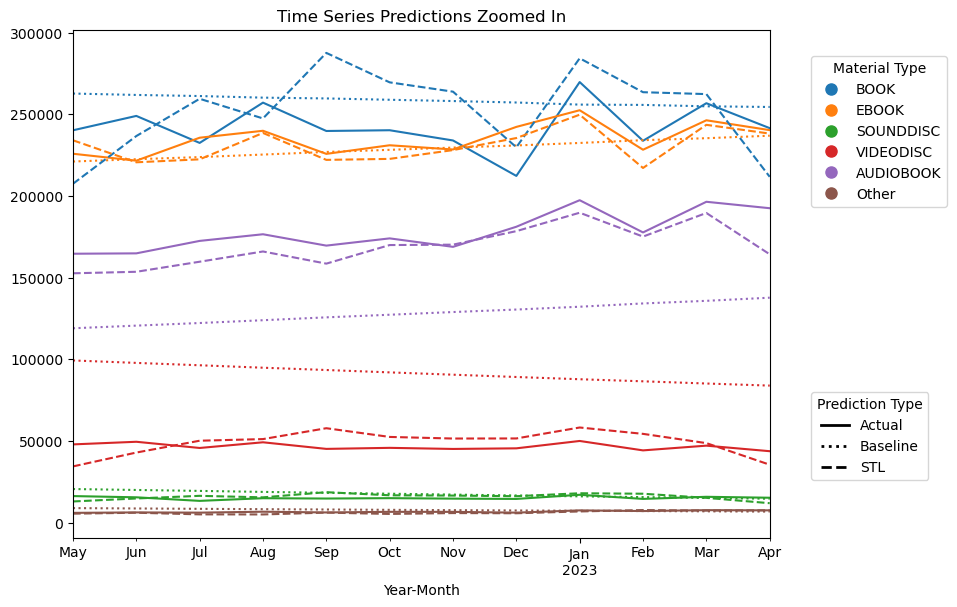

In [327]:
#Get true values of df_train at predicted indices
df_train_end = df_train[df_train.index >= baseline_preds.index[0]]

# Define corresponding colors for materials
colors = dict(zip(materials, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']))

# Define linestyles for different prediction types
linestyles = {'Actual': '-', 'Baseline': ':', 'STL': '--'}

# Plot predictions with whole time series
fig, ax = plt.subplots(figsize=(12, 6))
df_train_end.plot(x='Year-Month', y=materials, color=colors, ax=ax)
baseline_preds.plot(x='Year-Month', y=materials, ls=linestyles['Baseline'], color=colors, ax=ax)
STL_preds.plot(x='Year-Month', y=materials, ls=linestyles['STL'], color=colors, ax=ax)

# Create custom legends
color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

# Add legends outside the plot
color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.05, 0.8))
ax.add_artist(color_legend)  # Add material type legend first
linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.05, 0.2))

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
plt.title('Time Series Predictions Zoomed In')
plt.show()

We now want to compute the RMSE: 

In [328]:
from sklearn.metrics import root_mean_squared_error as rmse

In [329]:
first_idx = baseline_preds.index.values[0]
last_idx = baseline_preds.index.values[-1]

df_errors=pd.DataFrame(index=['Baseline', 'STLForecasting'], columns=materials)


for feature in materials:
    df_errors.loc['Baseline',feature]=rmse(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=baseline_preds[feature].values)
    df_errors.loc['STLForecasting',feature]=rmse(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=STL_preds[feature].values)


In [330]:
df_errors

,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
Baseline,21786.723688,9501.078326,3216.909852,45040.005636,50365.3569,1606.195251
STLForecasting,26468.996672,6583.302484,2382.887834,8020.52424,11545.20301,788.939531


### Baseline Prediction Option #2: Seasonal Naive with Trend


This model adds a trend component to the seasonal naive forecast:

$$
f(t) = \left\lbrace \begin{array}{l c c}y_\tau + \beta(t-n) + \epsilon, & \text{for} & t > n  \\
                                        y_t & \text{for} & t\leq n
                                        \end{array}\right.,
$$

where 

$$
\tau = t - \left(\left\lfloor \frac{t - n}{m} \right\rfloor + 1\right) m, \text{ with } \lfloor \bullet \rfloor \text{ denoting the floor function.} 
$$
Here a season lasts $m$ timesteps and $\beta$ can be estimated with the average value of the first seasonal differences $\nabla y_t = y_t - y_{t-m}$

In [332]:
# Time Series Cross Valididation object
tscv=TimeSeriesSplit(n_splits=12, test_size=1)

# Dictionary to go from Year-Month to row index of df
month_dict = dict(zip(df['Year-Month'], df.index))

# Baseline prediction
baseline_preds_option2=pd.DataFrame(index=df_train.index, columns=materials)
# STL predictions
STL_preds=pd.DataFrame(index=df_train['Year-Month'], columns=materials)

for train_index, test_index in tscv.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    for material in materials: 
        #Baseline Predictions
        beta_hat = df_tt[material].diff(12).mean()/12.0
        data= df_tt[material].values
        baseline_preds_option2.loc[test_index,material] = data[test_index-12] + beta_hat*(test_index-len(df_tt))

        #STL Predictions
        df_seasonal = pd.DataFrame(df_tt[material].values, index=df_tt['Year-Month'], columns=[material])
        df_seasonal = df_seasonal.asfreq('MS')
        stlf = STLForecast(df_seasonal, ARIMA, model_kwargs=dict(order=orders_preCOVID_dict[material], freq=df_seasonal.index.inferred_freq))
        stlf_res = stlf.fit()
        forecast = stlf_res.forecast(1)
        date = forecast.index.to_pydatetime()[0]
        STL_preds.loc[date,material]= forecast.values[0]


STL_preds = STL_preds.reset_index().dropna()
baseline_preds_option2.insert(0,'Year-Month', df_train['Year-Month'])
baseline_preds_option2 = baseline_preds_option2.dropna()


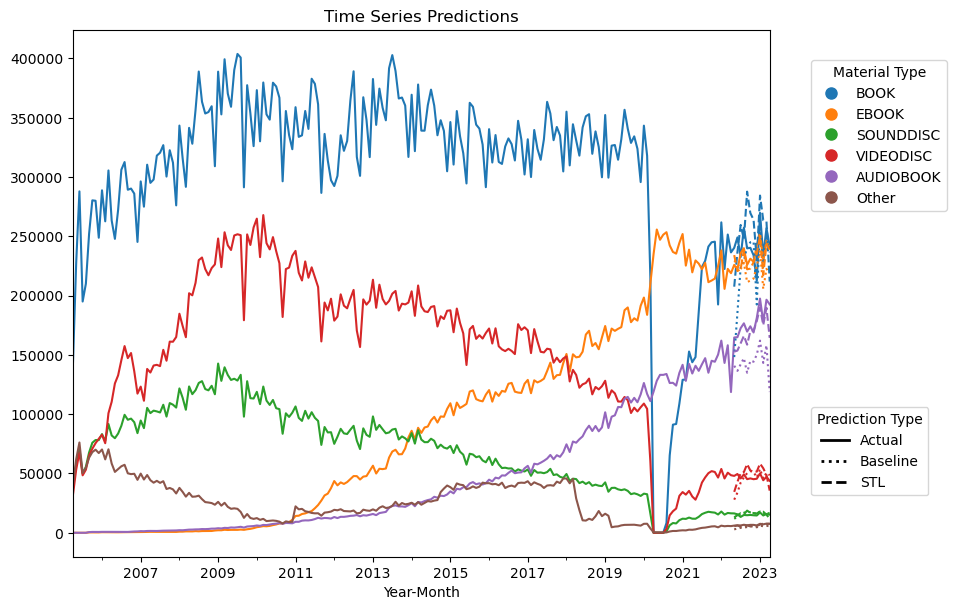

In [333]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Define corresponding colors for materials
colors = dict(zip(materials, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']))

# Define linestyles for different prediction types
linestyles = {'Actual': '-', 'Baseline': ':', 'STL': '--'}

# Plot predictions with whole time series
fig, ax = plt.subplots(figsize=(12, 6))
df_train.plot(x='Year-Month', y=materials, color=colors, ax=ax)
baseline_preds_option2.plot(x='Year-Month', y=materials, ls=linestyles['Baseline'], color=colors, ax=ax)
STL_preds.plot(x='Year-Month', y=materials, ls=linestyles['STL'], color=colors, ax=ax)

# Create custom legends
color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

# Add legends outside the plot
color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.05, 0.8))
ax.add_artist(color_legend)  # Add material type legend first
linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.05, 0.2))

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
plt.title('Time Series Predictions')
plt.show()

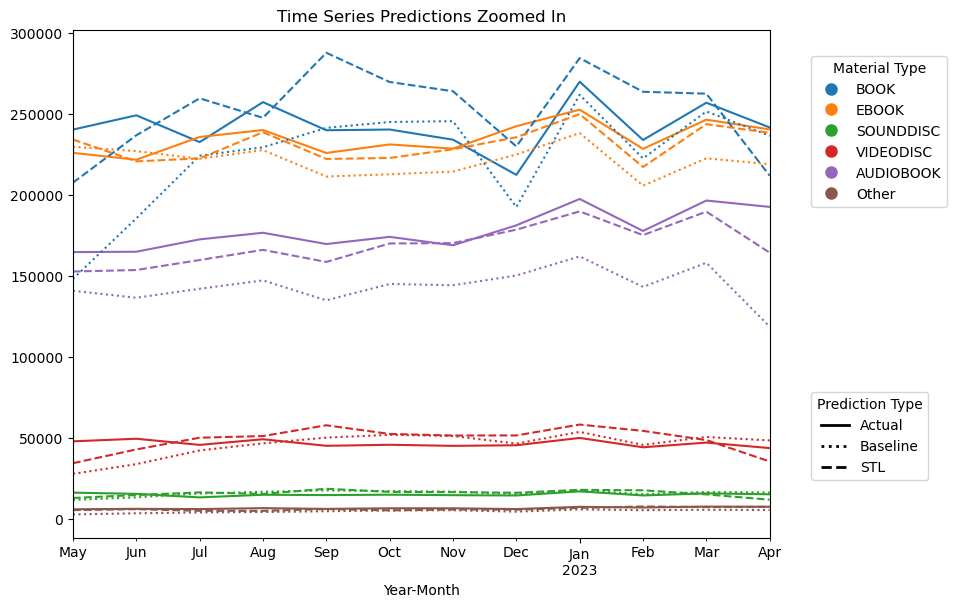

In [334]:
#Get true values of df_train at predicted indices
df_train_end = df_train[df_train.index >= baseline_preds.index[0]]

# Define corresponding colors for materials
colors = dict(zip(materials, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']))

# Define linestyles for different prediction types
linestyles = {'Actual': '-', 'Baseline': ':', 'STL': '--'}

# Plot predictions with whole time series
fig, ax = plt.subplots(figsize=(12, 6))
df_train_end.plot(x='Year-Month', y=materials, color=colors, ax=ax)
baseline_preds_option2.plot(x='Year-Month', y=materials, ls=linestyles['Baseline'], color=colors, ax=ax)
STL_preds.plot(x='Year-Month', y=materials, ls=linestyles['STL'], color=colors, ax=ax)

# Create custom legends
color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

# Add legends outside the plot
color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.05, 0.8))
ax.add_artist(color_legend)  # Add material type legend first
linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.05, 0.2))

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
plt.title('Time Series Predictions Zoomed In')
plt.show()

We now want to figure out the RMSE for each prediction. 

In [335]:
first_idx = baseline_preds.index.values[0]
last_idx = baseline_preds.index.values[-1]

df_errors=pd.DataFrame(index=['Baseline', 'STLForecasting'], columns=materials)


for feature in materials:
    df_errors.loc['Baseline',feature]=rmse(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=baseline_preds_option2[feature].values)
    df_errors.loc['STLForecasting',feature]=rmse(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=STL_preds[feature].values)


In [336]:
df_errors

,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
Baseline,34361.903964,16291.775494,2156.597919,8252.751703,36703.390538,1998.638328
STLForecasting,26468.996672,6583.302484,2382.887834,8020.52424,11545.20301,788.939531
